In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_score, recall_score, precision_recall_curve, recall_score, plot_roc_curve)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 0. Загрузка данных

In [2]:
df = pd.read_csv('../content/Loan_Data.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## 1. Базовое решение

### 1.1 Удаление пропущенных значений

In [3]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [4]:
# все-таки посчитаем переменную 'Depndents' за вещественную
df.loc[df['Dependents'] == '3+', 'Dependents'] = 4

In [5]:
num_features = ['Dependents', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

from sklearn.impute import SimpleImputer

si_med = SimpleImputer(strategy='median')
si_med.fit(df[num_features])

# si_med.statistics_

SimpleImputer(strategy='median')

In [6]:
df[num_features] = si_med.transform(df[num_features])
df[num_features].isna().sum()

Dependents          0
LoanAmount          0
Loan_Amount_Term    0
Credit_History      0
dtype: int64

### 1.2 Удаление всех категориальных переменных (и не имеющих информационной ценности)

In [7]:
df.drop(columns=
        ['Loan_ID', 'Gender', 'Married'
         , 'Education', 'Self_Employed', 'Property_Area']
         , inplace=True)
df.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
0,0.0,5849,0.0,128.0,360.0,1.0,Y
1,1.0,4583,1508.0,128.0,360.0,1.0,N
2,0.0,3000,0.0,66.0,360.0,1.0,Y
3,0.0,2583,2358.0,120.0,360.0,1.0,Y
4,0.0,6000,0.0,141.0,360.0,1.0,Y


In [8]:
# преобразуем метки целевого признака в числовые значения

df.loc[df['Loan_Status'] == 'Y', 'Loan_Status'] = 1
df.loc[df['Loan_Status'] == 'N', 'Loan_Status'] = 0
df.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
0,0.0,5849,0.0,128.0,360.0,1.0,1
1,1.0,4583,1508.0,128.0,360.0,1.0,0
2,0.0,3000,0.0,66.0,360.0,1.0,1
3,0.0,2583,2358.0,120.0,360.0,1.0,1
4,0.0,6000,0.0,141.0,360.0,1.0,1


### 1.3 Обучение модели

In [9]:
X = df.drop(columns='Loan_Status')
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,             # применим из-за дисбаланса классов
                                                    random_state=42)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

X_train.shape, X_test.shape

((491, 6), (123, 6))

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [11]:
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

# pred_proba_test = lr.predict_proba(X_test)

### 1.4 Подсчет метрик качества

In [12]:
# для train'а
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.91      0.40      0.56       154
           1       0.78      0.98      0.87       337

    accuracy                           0.80       491
   macro avg       0.85      0.69      0.71       491
weighted avg       0.82      0.80      0.77       491



In [13]:
# для test'а
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123



<Figure size 1200x1200 with 0 Axes>

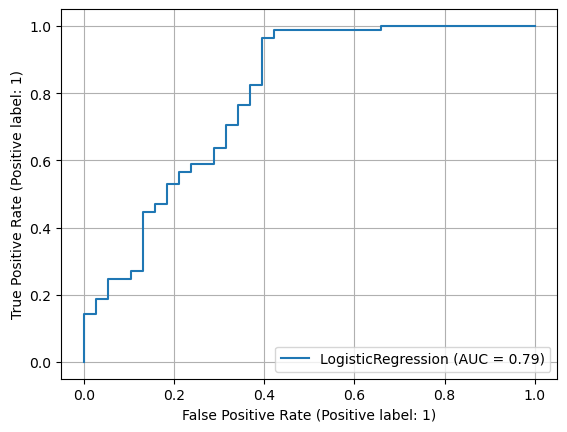

In [14]:
plt.figure(figsize=(12, 12))
plot_roc_curve(lr, X_test, y_test)
plt.grid(True)

**Выводы по базовому решению**:

Гармоническое среднее ($F^1$-мера) на `test`'е получилось равным 0.81 (для макроусреднения, потому как имеется дисбаланс классов). Метрика `ROC-AUC` = 0.79

## 2. Первичный анализ данных

In [15]:
df = pd.read_csv('../content/Loan_Data.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [17]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


Датасет имеет 614 наблюдений, в некоторых признаках имеются пропуски. Всего 13 признаков: 5 числовых, 8 категориальных. Целевой признак - `Loan_Status`.

Сразу избавимся от признака `Loan_ID` как от неинформативного:

In [18]:
df.drop(columns='Loan_ID', inplace=True)
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Распределение пропусков по признакам:

In [19]:
df.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

## 3. Визуальный анализ данных

In [20]:
num_features = ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
bin_features = ['Credit_History']
cat_features = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

### 3.1 Вещественные признаки

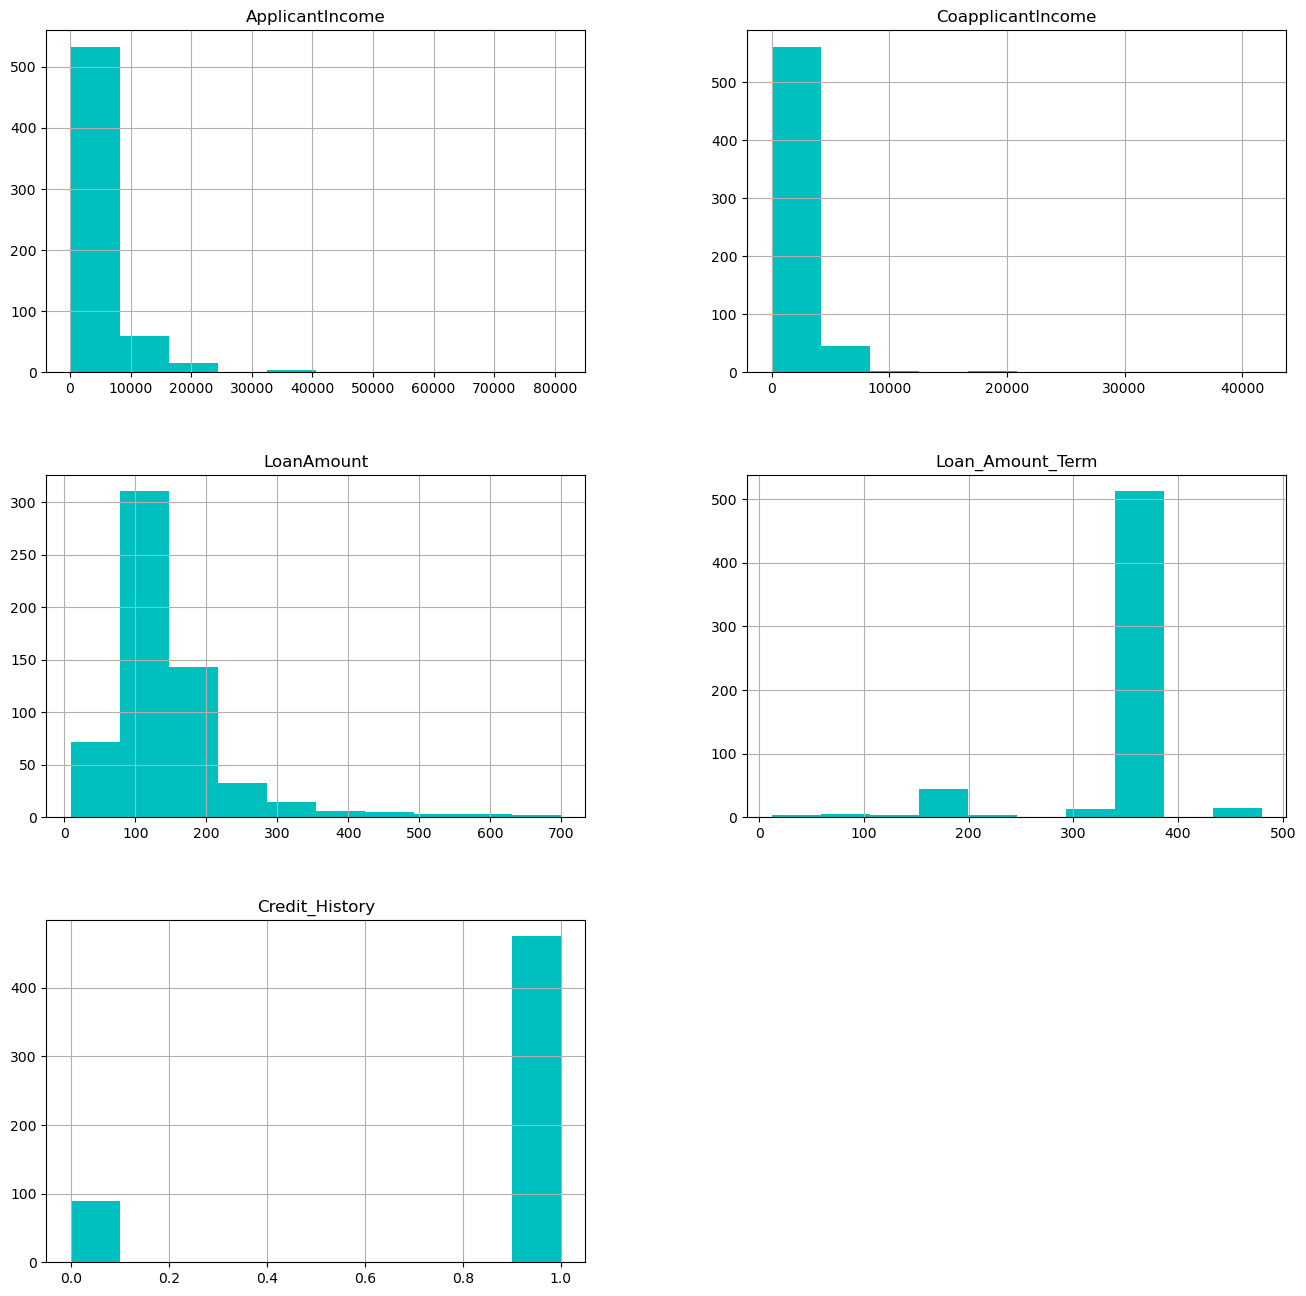

In [21]:
df[num_features + bin_features].hist(figsize=(16, 16), color='c');

# здесь не будет гистограммы для признака 'Dependents', потому что pandas считает его категориальным, мы его ещё не обрабатывали

Признаки `ApplicantIncome`, `CoapplicantIncome`, `LoanAmount`, `Loan_Amount_Term` имеют выбросы:

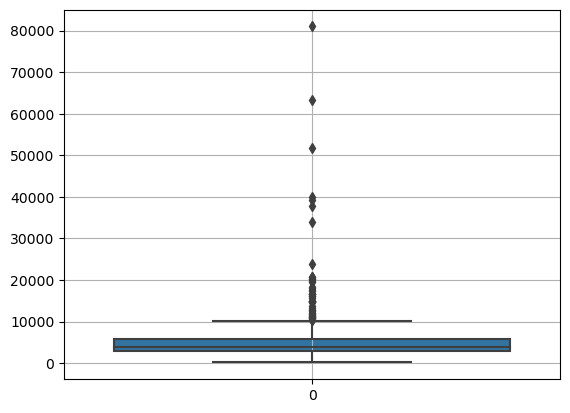

In [22]:
sns.boxplot(df['ApplicantIncome'], whis=1.5)
plt.grid(True);

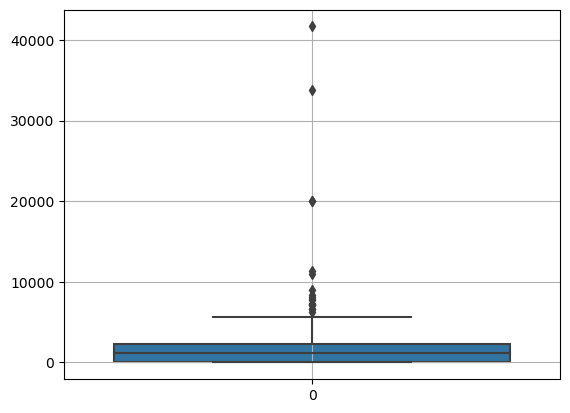

In [23]:
sns.boxplot(df['CoapplicantIncome'], whis=1.5)
plt.grid(True);

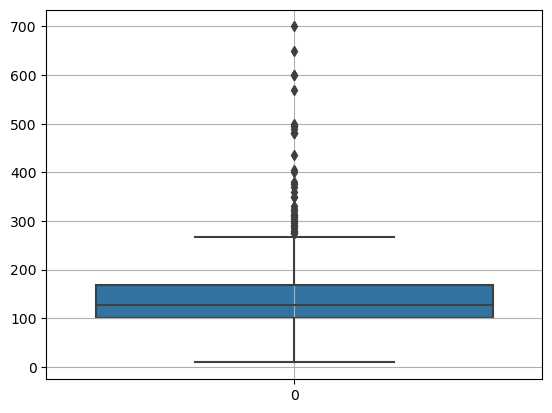

In [24]:
sns.boxplot(df['LoanAmount'], whis=1.5)
plt.grid(True);

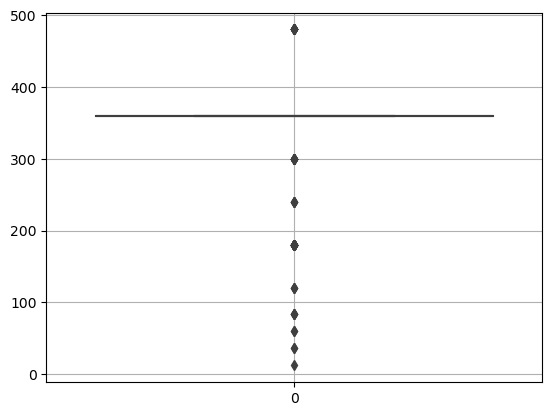

In [25]:
sns.boxplot(df['Loan_Amount_Term'], whis=1.5)
plt.grid(True);

### 3.2 Категориальные признаки

In [26]:
for cat_feature in cat_features:
    print(str(df[cat_feature].value_counts()) + '\n' + '*' * 50)
    

Male      489
Female    112
Name: Gender, dtype: int64
**************************************************
Yes    398
No     213
Name: Married, dtype: int64
**************************************************
Graduate        480
Not Graduate    134
Name: Education, dtype: int64
**************************************************
No     500
Yes     82
Name: Self_Employed, dtype: int64
**************************************************
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64
**************************************************
Y    422
N    192
Name: Loan_Status, dtype: int64
**************************************************


Почти везде имеется дисбаланс классов

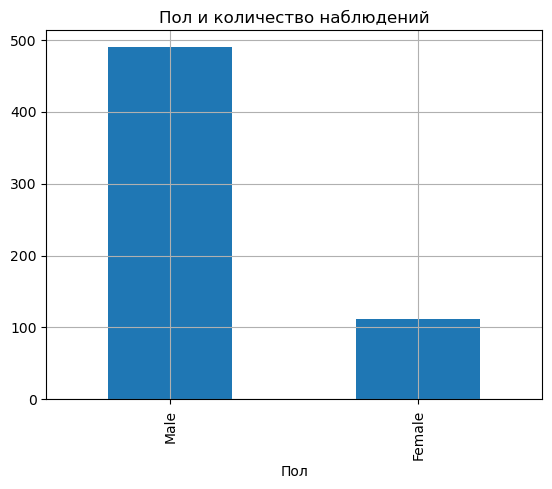

In [27]:
gender_counts_df = df["Gender"].value_counts().reset_index()
gender_counts_df.columns = ["Gender", "counts"]

gender_counts_df.plot(x="Gender", title='Пол и количество наблюдений'
                     , kind='bar'
                     , legend=False
                     , xlabel='Пол'
                     , grid=True);

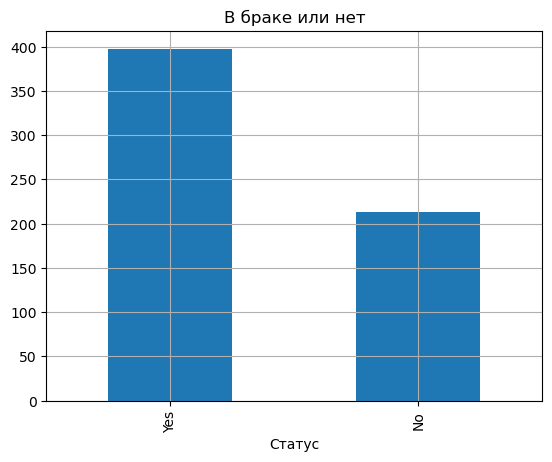

In [28]:
married_counts_df = df["Married"].value_counts().reset_index()
married_counts_df.columns = ["Married", "counts"]

married_counts_df.plot(x="Married", title='В браке или нет'
                     , kind='bar'
                     , legend=False
                     , xlabel='Статус'
                     , grid=True);

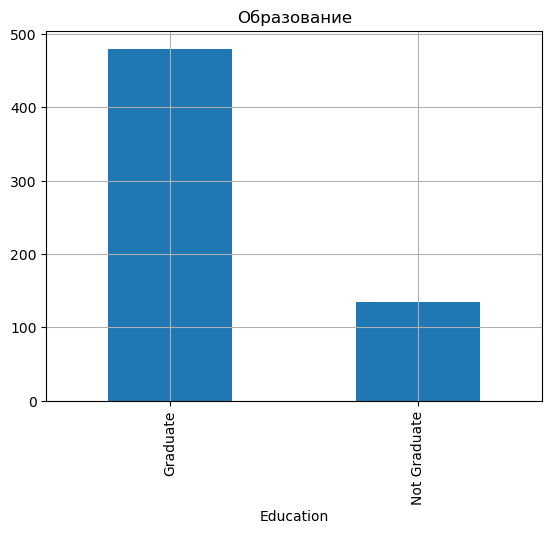

In [29]:
education_counts_df = df["Education"].value_counts().reset_index()
education_counts_df.columns = ["Education", "counts"]

education_counts_df.plot(x="Education", title='Образование'
                     , kind='bar'
                     , legend=False
                    #  , xlabel='Образование'
                     , grid=True);

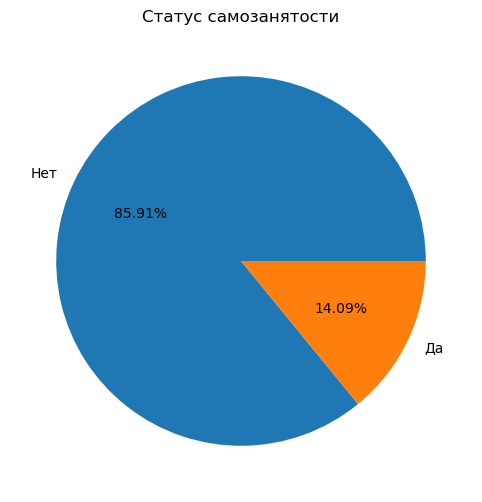

In [30]:
self_employing_counts_df = df["Self_Employed"].value_counts()

plt.figure(figsize=(10, 6))
plt.title('Статус самозанятости')
plt.pie(self_employing_counts_df.values
        , labels=["Нет", "Да"]
        , autopct='%.2f%%'
        );

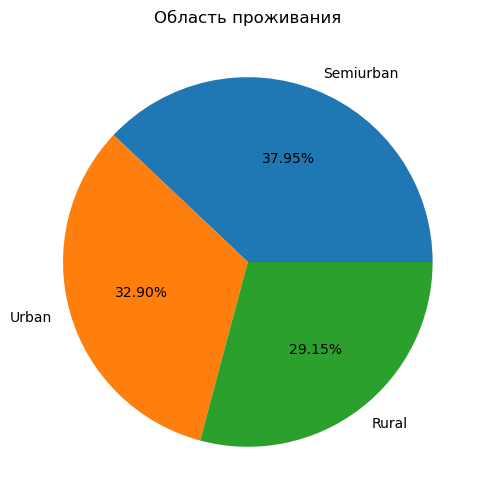

In [31]:
property_area_counts_df = df["Property_Area"].value_counts()

plt.figure(figsize=(10, 6))
plt.title('Область проживания')
plt.pie(property_area_counts_df.values
        , labels=property_area_counts_df.index
        , autopct='%.2f%%'
        );


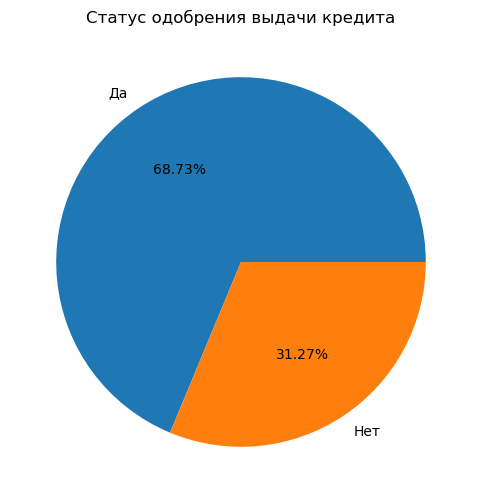

In [32]:
loan_status_counts_df = df["Loan_Status"].value_counts()

plt.figure(figsize=(10, 6))
plt.title('Статус одобрения выдачи кредита')
plt.pie(loan_status_counts_df.values
        , labels=["Да", "Нет"]
        , autopct='%.2f%%'
        );


### 3.3 Матрица корреляций

## 4. Разделение данных на обучающие и тестовые выборки

### 4.1 Преобразование меток целевого признака в бинарные

In [33]:
# преобразуем метки целевого признака в бинарные

df.loc[df['Loan_Status'] == 'Y', 'Loan_Status'] = 1
df.loc[df['Loan_Status'] == 'N', 'Loan_Status'] = 0

### 4.2 Разделение данных

In [34]:
X = df.drop(columns='Loan_Status')
y = df['Loan_Status']

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,             # из-за дисбаланса классов
                                                    random_state=42)
y_train = y_train_orig.astype(int)
y_test = y_test_orig.astype(int)

X_train_orig.shape, X_test_orig.shape

((491, 11), (123, 11))

### 5. Предобработка данных с помощью класса и пайплайна

### 5.1 Обработка вещественных признаков

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataPipeline(BaseEstimator, TransformerMixin):
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        # максимальные значения
        self.applicant_income_max = None
        self.coapplicant_income_max = None
        self.loan_amount_max = None
        self.loan_amount_term_max = None
        self.loan_amount_term_min = None

        # средние значения
        self.applicant_income_mean = None
        self.coapplicant_income_mean = None
        self.loan_amount_mean = None
        self.loan_amount_term_mean = None

    def fit(self, df, y=None):
        """Сохранение статистик"""
        # максимумы на глазок
        
        if 'ApplicantIncome' in df.columns:
            self.applicant_income_max = 25_000
            self.applicant_income_mean = df['ApplicantIncome'].mean()
        if 'CoapplicantIncome' in df.columns:
            self.coapplicant_income_max = 6_000
            self.coapplicant_income_mean = df['CoapplicantIncome'].mean()
        if 'LoanAmount' in df.columns:
            self.loan_amount_max = 275
            self.loan_amount_mean = df['LoanAmount'].mean()
        if 'Loan_Amount_Term' in df.columns:
            self.loan_amount_term_max = 400
            self.loan_amount_term_min = 200
            self.loan_amount_term_mean = df['Loan_Amount_Term'].mean()

        return self

    def transform(self, df, y=None):
        """Трансформация данных"""

        if 'Dependents' in df.columns:
            df.loc[df['Dependents'] == '3+', 'Dependents'] = 4
        if 'ApplicantIncome' in df.columns:
            df.loc[df['ApplicantIncome'] >= self.applicant_income_max, 'ApplicantIncome'] = self.applicant_income_mean
        if 'CoapplicantIncome' in df.columns:
            df.loc[df['CoapplicantIncome'] >= self.coapplicant_income_max, 'CoapplicantIncome'] = self.applicant_income_mean
        if 'LoanAmount' in df.columns:
            df.loc[df['LoanAmount'] >= self.loan_amount_max, 'LoanAmount'] = self.loan_amount_mean
        if 'Loan_Amount_Term' in df.columns:
            df.loc[(df['Loan_Amount_Term'] >= self.loan_amount_term_max) 
                   | (df['Loan_Amount_Term'] <= self.loan_amount_term_min), 'LoanAmount'] = self.loan_amount_mean       

        return df

In [36]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

pipe_num = make_pipeline(
    DataPipeline(),
    SimpleImputer(strategy='mean'),
    # StandardScaler()
    MinMaxScaler()

)
pipe_num

Pipeline(steps=[('datapipeline', DataPipeline()),
                ('simpleimputer', SimpleImputer()),
                ('minmaxscaler', MinMaxScaler())])

In [37]:
pipe_num.fit(X_train_orig[num_features])

Pipeline(steps=[('datapipeline', DataPipeline()),
                ('simpleimputer', SimpleImputer()),
                ('minmaxscaler', MinMaxScaler())])

In [38]:
X_train[num_features] = pipe_num.transform(X_train_orig[num_features])
X_test[num_features] = pipe_num.transform(X_test_orig[num_features])

### 5.2 Обработка категориальных признаков

#### 5.2.1 Заполнение пропусков

In [39]:
from sklearn.preprocessing import OneHotEncoder

pipe_cat = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    # OneHotEncoder()
);
# pipe_cat

In [40]:
cat_features.remove('Loan_Status')

In [41]:
pipe_cat.fit(X_train_orig[cat_features + bin_features])

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent'))])

In [42]:
X_train[cat_features + bin_features] = pipe_cat.transform(X_train_orig[cat_features + bin_features])
X_test[cat_features + bin_features] = pipe_cat.transform(X_test_orig[cat_features + bin_features])

#### 5.2.2 OneHotEncoding

In [45]:
def OHE(df, columns):

    for column in columns:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
    df.drop(columns=columns, inplace=True)

    return df

In [46]:
X_train = OHE(X_train, cat_features)
X_test = OHE(X_test, cat_features)

In [51]:
X_train.shape, X_test.shape

((491, 17), (123, 17))

### 6. Обучение модели классификации с целевым признаком `Loan_Status`

In [52]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [53]:
lr.coef_, lr.intercept_

(array([[ 0.24287618, -0.14131818,  0.04531316, -0.75004108,  0.03957931,
          3.13001459,  0.07128914, -0.07136485, -0.26887511,  0.2687994 ,
          0.19100483, -0.19108054,  0.07377293, -0.07384864, -0.28523384,
          0.45130228, -0.16614415]]),
 array([-1.7813033]))

In [54]:
pred_train = lr.predict(X_train)        # метки на трейне
pred_test = lr.predict(X_test)          # метки на тесте

pred_proba_test = lr.predict_proba(X_test)
pred_proba_test[:5]
# левый столбец - вероятности быть 0-ым классом, второй - 1-ым классом 

array([[0.92170827, 0.07829173],
       [0.12720228, 0.87279772],
       [0.2990219 , 0.7009781 ],
       [0.24487798, 0.75512202],
       [0.10040625, 0.89959375]])

### 7. Оценка подходящих метрик качества

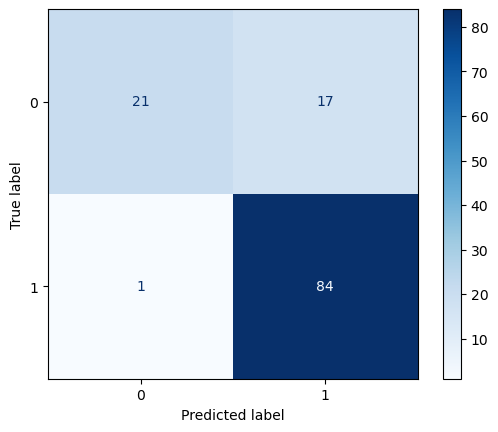

In [55]:
plot_confusion_matrix(lr, X_test, y_test, cmap=plt.cm.Blues,);

In [58]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.91      0.40      0.55       154
           1       0.78      0.98      0.87       337

    accuracy                           0.80       491
   macro avg       0.85      0.69      0.71       491
weighted avg       0.82      0.80      0.77       491



In [57]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.95      0.55      0.70        38
           1       0.83      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123



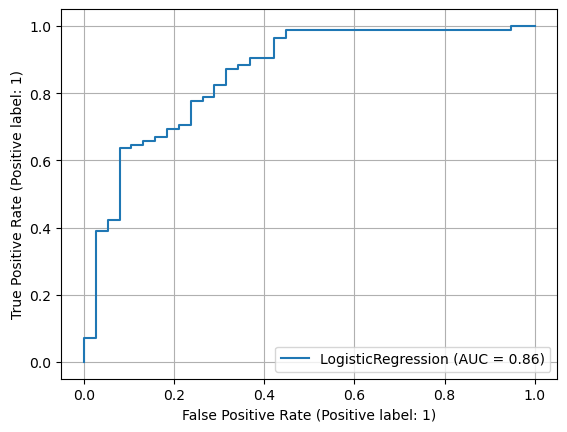

In [60]:
plot_roc_curve(lr, X_test, y_test)
plt.grid(True);